In [20]:
import numpy as np
import pandas as pd
import sframe as sf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from haversine import haversine
from IPython.display import Image

#NOTE: pip install sframe for installing sframe data structure (computationally efficient graph based dataframe)

## Description

The analysis contains the following three steps.

1) Spatial Analysis and Visualizaiton of data.

2) Clustering Analysis of large spatial data

3) Optimization for placement.

**Assumptions:**

Since there is no temporal information regarding the SOC or waiting time for TRIP_ID, it can be assumed that **availibility of charging stations should coincide with the starting and ending locations of trips**. This can be supported by a number of reasons:

1) **High density regions or clusters** represent a **higher probability of taxi presence**, therefore a driver will prefer to wait for full charging at such locations.
    
2) Likewise, **charging demand** can be inferred from the distribution of start and end locations.

3) Better to **charge while waiting than during a customer trip.**

The following analysis builds up on this assumption.


In [42]:
dests = sf.SFrame.read_csv("final_destination.csv", usecols=['STOP'])
starts = sf.SFrame.read_csv("final_destination.csv", usecols=['START'])
starts.head()

PROGRESS: Finished parsing file /Users/siddharth481/Documents/Job_Prep/final_destination.csv
PROGRESS: Parsing completed. Parsed 100 lines in 1.26155 secs.
------------------------------------------------------
Inferred types from first line of file as 
column_type_hints=[array]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------
PROGRESS: Read 1036635 lines. Lines per second: 585775
PROGRESS: Finished parsing file /Users/siddharth481/Documents/Job_Prep/final_destination.csv
PROGRESS: Parsing completed. Parsed 1704769 lines in 2.00712 secs.
PROGRESS: Finished parsing file /Users/siddharth481/Documents/Job_Prep/final_destination.csv
PROGRESS: Parsing completed. Parsed 100 lines in 1.21317 secs.
------------------------------------------------------
Inferred types from first line of file as 
column_type_hints=[array]
If parsing fails due to in

START
"[-8.61864, 41.1414]"
"[-8.63985, 41.1598]"
"[-8.61296, 41.1404]"
"[-8.57468, 41.152]"
"[-8.64599, 41.1805]"
"[-8.6155, 41.1407]"
"[-8.57952, 41.1459]"
"[-8.61756, 41.1462]"
"[-8.61179, 41.1406]"
"[-8.61591, 41.1406]"


### Limit to START and STOP locations. This reduces the dataset drastically. 

1. xy_stop()
2. xy_start()

In [43]:
xy_stop = dests.unique()
xy_start = starts.unique()
print 'Total examples: ',len(xy_stop),'Unique examples', len(xy_start)
xy_stop = xy_stop.unpack('STOP')
xy_stop.rename({'STOP.0':'lon',
               'STOP.1': 'lat'})

xy_start = xy_start.unpack('START')
xy_start.rename({'START.0':'lon',
               'START.1': 'lat'})
xy_start.head()
xy_stop.save('dests_unique', format='csv')
xy_start.save('starts', format='csv')

Total examples:  702460 Unique examples 382085


## Convert into numpy array
lon_lat (numpy array) : Destination Points

lon_lat_start (numpy array): Starting Points

In [44]:
df_stop = xy_stop.to_dataframe()
lon_lat = np.array(df_stop.values)
df_start = xy_start.to_dataframe()
lon_lat_start = np.array(df_start.values)

## Spatial Analysis -  Data Visualization and Clustering

**Assumption:** Introduction of charging stations doesn't affect the driving behaviour.

**Observation:**

Some daywise data exploration showed that while same TAXI_IDs make multiple multiple trips on the same day, the STOP point for a particular TRIP_ID doesn't necessarily overlap with the START point of the immediate next TRIP_ID. Although most of the times their grid indices do match. Therefore it can be inferred that taxis hover in the same or neighbouring region (cells) and thus their probability of being present in nearby regions increases. Since the number of taxis will be higher for such regions, their charging demand will also increase.

**Conclusion:**

Hence the **density (frequency, total count etc) of START and STOP points** in a particular grid cell can act as a fair **indicator for charging demands**.

To visualize the preprocessed dataset, we plot the unique points corresponding to the starting points and the destinations of all trips. Matplotlib doesn't have in-built support for handling spatial dataset. Therefore, CartoDB was used to visualize the this dataset.


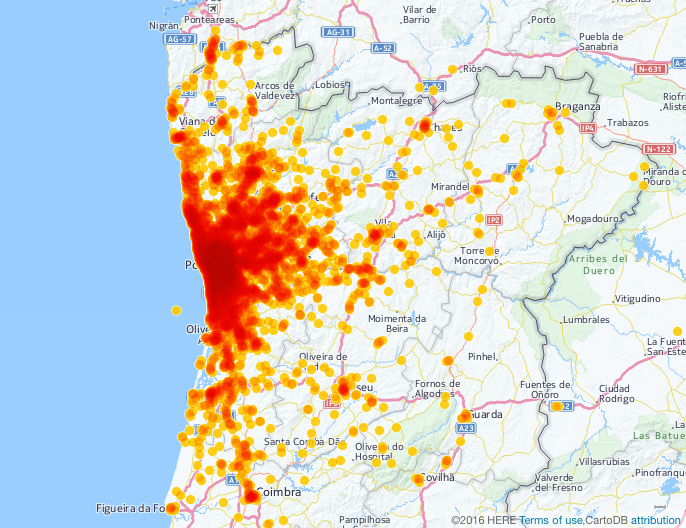

In [46]:
Image(filename="distribution_final.png")

Above, is an intensity plot of the start points and destinations corresponding to everytime in the dataset. It can be inferred that the center of the city is a highly dense region. There is also a visible small hotspot at the top. Otherwise, as we move away from the the city center a decreasing number of starting/destination points are encountered. 

## Spatial Indexing and Hashing: Reduction of spatial data


In order to place sufficient charging stations, it is important to identify spatial clusters. As explained earlier,  multiple consecutive trips didn't overlap exactly. The starting and ending locations of some trips correspond to the same 'location'. Location here is defined as a geographical area that can be assumed to be similar - shopping centers, market streets - where multiple taxi trips end & start but don't correspond to the exact same location. 

** Failure of clustering algorithms: **
Multiple instances mentioned above might help in *temporal analysis of data* (*How much time a taxi spends at a particular location?*). However for a spatial analysis (placement of charging stations) it is redundant. Additionally,  it is extremely difficult to run clustering algorithms that involve a distance computation as a similarity metric. Therefore I found any clustering algorithm that preserves the spatial distribution in data (heirarchical or DBSCAN) did not work and stalled my machine.  

    1) DBSCAN: Doesn't scale. Computationally very expensive for this huge data-space. As can be seen some points lie in the ocean and therefore do not need to be evaluated.
    2) K-means: Online/Mini-batch method does allow for clustering large datasets but didn't give good results, probably because it just minimizes variance and not haversine distance.

After several failed attempts a (using GraphLab for efficient data operations, quering and fitting the dataset in databses) I decided to **solve this problem by using the concept of hashing or spatial indexing.**

### Motivation for Spatial Indexing:

Grid indexing data reduces the neighborhood search space by a huge margin by binning similar data points (near duplicates) and thus the candidate space can be significantly reduced. Grid indexing also allows us to identify neighborhood data points on the fly based on spatial relationship between grid cells.

## Define parameters for Grid Indexing

1. Define size for each grid cell - 0.01 X 0.01 degrees (1.11 x 1.13 Km-sq)
2. Tessellate the entire space
3. Calculate the maximum number of rows and columns

In [47]:
#Maximum and Minimum latitude and longitudes of the Starting Points (lat_lon_start)
xmin, xmax = min(lon_lat_start[:,0]), max(lon_lat_start[:,0])
ymin, ymax = min(lon_lat_start[:,0]), max(lon_lat_start[:,1])
print 'Minimum Longitude: ', xmin, 'Maximum Longitude: ', xmax
print 'Minimum Lattitude: ', ymin, 'Maximum Lattitude: ', ymax

x_list, y_list = [], []
x_list.append(xmin)
x_list.append(xmax)
y_list.append(ymin)
y_list.append(ymax)


#Maximum and Minimum latitude and longitudes of the Final Destinations (lat_lon)
xmin, xmax = min(lon_lat[:,0]), max(lon_lat[:,0])
ymin, ymax = min(lon_lat[:,0]), max(lon_lat[:,1])
x_list.append(xmin)
x_list.append(xmax)
y_list.append(ymin)
y_list.append(ymax)

#Define the width for each grid cell
cell_size = 0.01 # 1.1 km-sq
print '\nCell size considered is 0.01 OR 1.11 km in width'

'''
For illustration purposes, the following code takes the (x,y) or (lon,lat) for a point and finds 
its corresponding spatial index in the given grid-space.

NOTE - While data exploration, I realized this is highly specific to the problem statement and the spatial distribution 
of the dataset at hand. This will be explained further.
'''
num_rows = np.floor((max(x_list) - min(x_list))/cell_size + 1)
num_cols = np.floor((max(y_list) - min(y_list))/cell_size + 1)
print '\nTotal Rows: ',num_rows,'Total Columns: ', num_cols
max_index = int(num_rows*(num_cols + 1) + num_cols)
print '\nMaximum Spatial Index: ', max_index


Minimum Longitude:  -36.9138 Maximum Longitude:  52.9008
Minimum Lattitude:  -36.9138 Maximum Lattitude:  51.0371

Cell size considered is 0.01 OR 1.11 km in width

Total Rows:  8982.0 Total Columns:  8796.0

Maximum Spatial Index:  79023450


## Spatial Indexing: Grid points and indexing each point

Following routines were written for going back and forth between geographicalal space (corresponding to latitude and longitude) and the grid space (spatial indexed space, tesselations of squares).

1. Index point P and add to grid
2. Get (row, col) from grid index. 
3. Get (row, col) from (lon, lat)
4. Get grid index from (lon, lat)
5. Get neighbouring indices from grid index.

In [48]:
'''
Takes point P (lat, long) in geographical space, finds the relevant spatial index for P 
and adds/bins it to the hashmap. As explained earlier, hashmap has entries of {key:value} pairs.
key (int) - spatial index
value (list) - a list of all points falling within this grid cell

Input (tuple) - (lat, long)
Output - None
'''
def add_point_grid(p):
    row, col = get_loc_point(p)
    index = row*(num_cols + 1) + col
    
    if (grid.has_key(index)):
        grid.get(index).append(p)
    else:
        grid[index] = []
        grid[index].append(p)
        
'''
Input - Spatial Index of the grid cell
Output = (row, column) of the grid cell
'''

def get_loc_index(index):
    x_coord = int(index/(num_cols + 1))
    y_coord = int(index % (num_cols + 1))
    
    return x_coord, y_coord

'''
Input (tuple) - Point P (lat, long)
Output (tuple)- (Row, Column) of the grid cell or bin.
'''
def get_loc_point(p):
    x_map = np.floor((p[0] - xmin)/cell_size + 1)
    y_map = np.floor((p[1] - ymin)/cell_size + 1)
    return x_map, y_map
'''
Input (tuple) - (row, column) of the grid cell
Output (int) - spatial index
'''
def get_index_grid(x_row, y_col):
    #x_row, y_col = get_loc_point(pt)
    index = (x_row * (num_cols + 1) + y_col)
    return index

'''
Input (int) - spatial grid index
Output (list) - list of indices of 8 nearest neighbours
'''
def get_neighbours(grid_index): #change to (x,y)
    '''
    Returns a list containing the neighbourhood cells.
    Immediate 8 neighbours. Design parameter, explained later.
    
    '''
    x_coord, y_coord = get_loc_index(grid_index)
    
    neighbour_index = []
    
    for i in range(-1,2): ##change here for max 21 neighbours.
        for j in range(-1,2):
            xn = x_coord + i
            yn = y_coord + j
            
            if (xn >= 1) and (xn <= num_rows) and (yn >= 1) and (yn <= num_cols):
                if (i != 0) or (j != 0):
                    neighbour_index.append(get_index_grid(xn,yn))
    
    return neighbour_index

print 'Test routine: '
print 'Neighbouring grid cells for spatial index :',  25026568.0,'\n', get_neighbours(25026568.0)
#a,b = get_loc_index(25026568.0)

Test routine: 
Neighbouring grid cells for spatial index : 25026568.0 
[25017770.0, 25017771.0, 25017772.0, 25026567.0, 25026569.0, 25035364.0, 25035365.0, 25035366.0]


## Justify the grid size by Haversine distance between points within a cell

Euclidean distance didn't give any meaningful interpretation. Therefore defined the Haversine Distance between two GPS data points. The distance between any two points having the same spatial index (or grid cell) should be less than the width of the grid cell i.e 1.1km (corresponding to 0.01 deg of lat-long).

**Density of each grid cell:** 
Density of each cell can be defined as the total number of points divided by  the volume of the cell. Since the volume of each grid cell is constant, we can safely say that **density is directly proportional to the total number of points.** 

Justification follows.

In [49]:
grid = {}

for p in lon_lat:
    add_point_grid(p)
    
for p in lon_lat_start: 
    add_point_grid(p)


k = 0
x = []
print 'Grid indices: '
for key in grid:
    if k <=10:
        x.append(grid[key])
    k +=1 

for i in x:
    print 'Total elements: ', len(i)

take = x[2]
take.sort

print '\nDistance between two points in a random grid cell \n'
for i in range(len(take)):
    if i < len(take)-1:
        print i+1, take[i], take[i+1],'Distance in meters:', 1000*haversine(take[i], take[i+1])


Grid indices: 
Total elements:  1
Total elements:  2
Total elements:  5
Total elements:  1
Total elements:  3
Total elements:  1
Total elements:  1
Total elements:  1
Total elements:  1
Total elements:  1
Total elements:  1

Distance between two points in a random grid cell 

1 [ -8.75043  41.53   ] [ -8.75042  41.53   ] Distance in meters: 1.11194926642
2 [ -8.75042  41.53   ] [ -8.74702  41.5347 ] Distance in meters: 640.109626206
3 [ -8.74702  41.5347 ] [ -8.75043  41.53   ] Distance in meters: 640.766990428
4 [ -8.75043  41.53   ] [ -8.75042  41.53   ] Distance in meters: 1.11194926642


### Analysis:

As can be seen above (please verify for multiple cases), grid width of 1.1km or grid-cell size of 1.11 X 1.11 km-square is a good approximation. For example, in the in first pair displayed:

**1. [-8.75043, 41.53] [-8.75042, 41.53] Distance in meters: 1.11194926642**

The distance between the two points is 1.1 meters. These essentially refer to the exact same point. **Binning such values together greatly reduces the data space.** On the other hand the distance between the second pair of points is 640 meters. These points can be grouped into one cluster/cell since a driver can always travel a distance of 640 meters for charging the vehicle. The maximum distance as state earlier, can be the diagonal or the width of the square.

## Create a hash-map for the dataset: Bin each point P to a grid-cell and assign an index.

This maps/hashes/bins the entire dataset of (lat, long) into grid cells with a spatial index.

Fill **grid_hash {}** with list of points. 


In [50]:
grid_hash = {} # key-value pairs for the spatial index and list of points that fall into this grid cell. 

for p in lon_lat:
    #assign p to a grid index in grid_hash
    row = np.floor((p[0] - xmin)/cell_size + 1)
    col = np.floor((p[1] - ymin)/cell_size + 1)
    index = row*(num_cols + 1) + col 
    
    if (grid_hash.has_key(index)):
        p = tuple(p) ##made the FINAL edit for typecasting
        grid_hash.get(index).append(p) 
    else:
        grid_hash[index] = []
        p = tuple(p) ##FINAL edit. 
        grid_hash[index].append(p) 

for p in lon_lat_start:
    #assign p to a grid index in grid_hash
    row = np.floor((p[0] - xmin)/cell_size + 1)
    col = np.floor((p[1] - ymin)/cell_size + 1)
    index = row*(num_cols + 1) + col 
    
    if (grid_hash.has_key(index)):
        p = tuple(p) ##made the FINAL edit for typecasting
        grid_hash.get(index).append(p) 
    else:
        grid_hash[index] = []
        p = tuple(p) ##FINAL edit. 
        grid_hash[index].append(p) 


print 'Total number of grid cells used for binning: ', len(grid_hash)


Total number of grid cells used for binning:  2862


### Cluster Class: create objects of clusters

In [51]:
class cluster:
    """
    Class for creating cluster objects.
    Each cluster should have a name and be able to: 
    1. addpoint
    2. return all points
    3. check point
    4. print points
    5. erase all points ????
    6. get X and Y of the cluster ??

    * Grid objects
    """

    def __init__(self, name, grid_index, pList):
        self.name = name #name of the cluster - cluster1, cluster2 ...
        self.pList = pList
        self.grid_index = grid_index
        
    def has_point(self, point):
        if point in self.pList:
            return True
        else:
            return False
        
    def printPoints(self):
        print self.name + "Points: "
        print '------------'
        print self.pList
        print len(self.pList)
        print '------------'

### Start with assigning a cluster object to each grid cell.
### Create a hashmap for clusters. 

cluster_hash = { }

**Key:** Spatial Index of the centroid 

**Value:** Cluster Object

All initial clusters will be equal to the grid cells in the grid hashmap *grid_hash*

In [52]:
count = 1
cluster_hash = {} #key-value pairs of centroid-index
for cell in grid_hash:
    name = 'Cluster' + str(count)
    cluster_hash[cell] = cluster(name, cell, grid_hash[cell])
    count +=1 
print 'Total initial clusters', len(cluster_hash)

Total initial clusters 2862


## Neighbourhood of a grid cell

The following image helps in visualizing the grid cells and the grid-space. Each number in the grid cell refers to its spatial index.

For the red point in grid cell with spatial index 10, the neighbourhood can be defined as the set of cells with the the following spatial indices = {5,6,7,11,15,14,13,9}



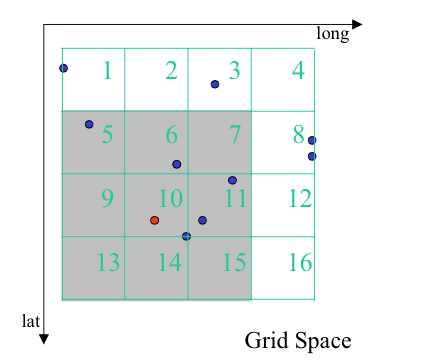

In [53]:
Image(filename="neighbours.png")

Therefore any operation for a particular point is now performed within this grid space with points in its neighbourhood.

**NOTE** - Size or width of the grid cells is chosen such as it makes sense geographically/spatially.

### Centroid Routine: Takes in a list of points (of a cluster) and returns the centroid of the point

In [54]:
def centroid(data):
    x, y = zip(*data)
    l = len(x)
    return sum(x) / l, sum(y) / l

## Grid Based clustering algorithm 

This method first partitions/quantizes the entire space to a grid structure with a certain number of square cells. This helps achieve computational efficiency. Instead of 'n' total number of points, the algorithm now depends upon 'N' the number of grid cells in the 2D space.

**Assumption:** Each cluster object's spatial index is determined by the spatial index of its centroid. 

1. **EACH CELL ** is assigned a **CLUSTER** object. 
2. **FOR EACH CELL Ck** find the **NEIGHBOURING CELLS** (maximum of 8).        
3. **CHECK IF EACH Cm** in neighbouring cells is assigned a **CLUSTER** object (verify if non-empty)
4. **FOR EACH CELL Cm** containing a cluster object, calculate the **distance between the centroid of Ck and Cm.** 
5. **MERGE** all clusters within **merge_dist**.

The algorithm can be broken down into three steps:

1. **Paritioning/Griding** the data (done above)
2. Determine the **nearest neighbours for each cluster**.
3. **Merge clusters** that satisfy the distance criteria (variable **merge_dist**)

In [55]:
#Merging Routine
#1. Check for merging.
#2. Update the cluster_hash (centroid, elements of cluster object etc).

merge_dist = 2.0 # 2kms for merging clusters set according to vehicle design spec.
total = 4

print 'Clusters before merging:', len(cluster_hash)
print 'Merge any cluster within a radius of ', merge_dist

while (total >= 1):
    all_keys = cluster_hash.keys()
    print '\n', total, len(all_keys)
    for k in all_keys:
        
        #1. Neighbourhood Search: Get indices for all neighbours
        #2. For each cluster in neighbours_list compare distance and check for merging.
        dist_prev = merge_dist
        keep_index = -1
        total_list, del_index = [], []
        
        if cluster_hash.has_key(k):
            Ck = cluster_hash[k] #cluster object Ck
        else:
            continue
       
        Ck_centr = centroid(Ck.pList) #(x,y) of centroid
        neighbours_list = get_neighbours(Ck.grid_index) #gets neighbours of centroid index
      
        #neighbours of cluster Ck, DON'T have to be cluster centroids.
        for each_index in neighbours_list:
            if cluster_hash.has_key(each_index):
                Cm = cluster_hash[each_index] #cluster object Cm
                Cm_centr = centroid(Cm.pList) #(x,y) of centroid Cm
                dist = haversine(Ck_centr, Cm_centr)
                #dist = np.amin(cdist(Ck.pList,Cm.pList)) 
                if dist <= dist_prev:
                    total_list += Cm.pList
                    del_index.append(each_index)
                    keep_index = 1
                    
            else:
                continue
        
        if keep_index != -1:
            '''1. merge clusters
            2. update centroid of merged cluster
            3. calculate the centroid of merged cluster
            4. find index of merged cluster
            5. update and assign relevant index 
            6. delete merged indices and the older Ck index'''
            
            Ck.pList += total_list
            new_p = centroid(Ck.pList) #find centroid of merged cluster
            new_x, new_y = get_loc_point(new_p)
            new_index = get_index_grid(new_x, new_y) #find index of new centroid
            Ck.grid_index = new_index #update grid index merged Ck with new centroid
            cluster_hash[new_index] = Ck # assign merged Ck
           
            for keys in del_index:
                del cluster_hash[keys]
            del cluster_hash[k]
    
    total -= 1

print 'Clusters after merging: ', len(cluster_hash)

Clusters before merging: 2862
Merge any cluster within a radius of  2.0

4 2862

3 587

2 587

1 587
Clusters after merging:  587


## Placement of Charging Stations:

So far, the focus has been on finding regions/locations (grid cells or area) in which charging stations should be placed, rather than exact coordinates. Clusters can be tuned by changing the **merge_dist** variable such that it is representative of the actual scenario. The exact location within an area can be better identified by considering constraints on factors like:

    1) Capacity and total number charging station.
    2) Expected demand 
    3) Walking or driving distance (depends on how the vehicle range and energy capacity -- explained further)
    4) Location specific placement cost.
    
This can be framed as a linear optimization problem and optimized for various objectives (minimizing costs, minizing walking distance to the nearest station. Popular facility location problem)

## Visualize candidate locations:

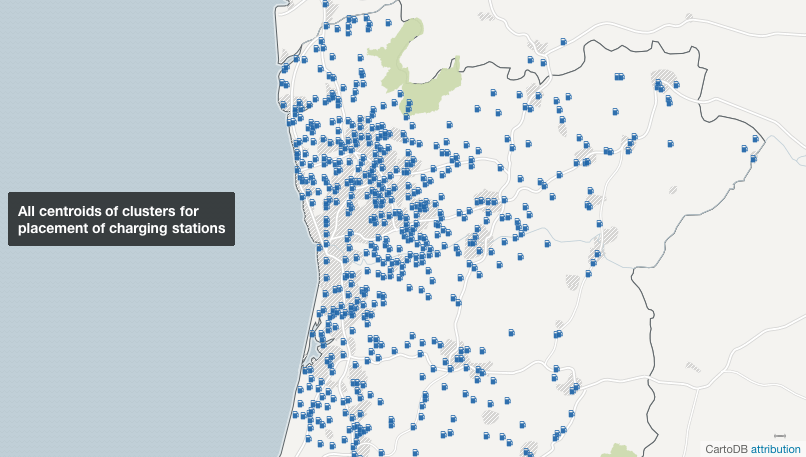

In [56]:
from IPython.display import display, Math, Latex
'''Map made in CartoDB 
   All maps also attached in the folder for better inspection
'''
Image(filename="all_candidate_sites_final.png")


As can be seen from the above graph, more candidate locations are available around the city center. 

## Optimal Placement:

**Optimal Placement of X charging stations:** 

The image above shows all the 587 identified candidate sites for the placement of charging stations. These sites correspond to the **coordinates of the centroids of the clusters** and since each charging station has infinite capacity and instataneous charging, it has been assumed that it can serve all the available vehicles within a cluster. 
Most importantly, they are clusters of points within 2km (merge_dist) of each other and therefore holds significance spatially. 2kms can be assumed to be a drivable distance to the nearest charging station for a 60km range vehicle on low SOC. 

---
*Restating:* Since there is no temporal information regarding the SOC and wait times for a TRIP_ID, it can be assumed that **availibility of charging stations should coincide with the starting and ending locations of trips**. This can be supported by a number of reasons

1) **High density regions or clusters** represent **high probability of taxi presence**, therefore a driver will prefer to wait for charging at such a location.
    
2) Likewise, **charging demand** can be inferred from the distribution of start and end locations.

3) Better to **charge while waiting than during a trip.**

---
**Heuristically:**

In cases we are provided with minor deviations, like say, if charging stations have a **limited capacity** (can serve less vehicles) but **sufficient number**, the assignment can also be done heuristically. The **candidate locations represent the spatial distribution of demand clusters**. Density (total points) for the relevant cluster can be identified from the key:value pair and assignment can be done proportionally. 

**Linear Optimization:**

**However**, in a scenario where only X (less than 587) charging stations are to be placed in the city, a linear optimization can be solved. Below is a linear optimization routine that considers the density of each cluster as a weighing factor for placement. 






For fixed number of charging stations R, find the assignment that corresponds to the maximal coverage. The objective function is a linear weighted sum. Weights *d_i* correspond to the density of the clusters i.e number of start/stop points.

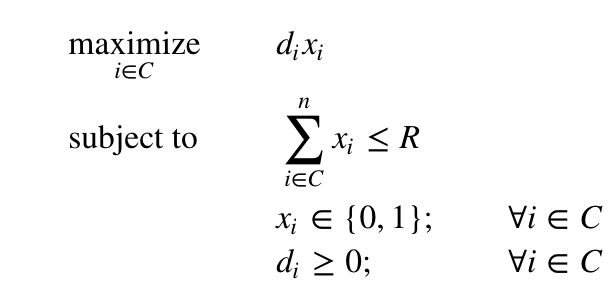

In [57]:
Image(filename="optimization.png")

### Conclusion:

Thus spatial coverage and density (by correctly choosing the grid cell size and solving the optimization equation) have both been considered in the analysis. Efficient spatial indexing/harshing reduced the computational burden of the clustering algorithm by limiting the comparisons to neighbouring cells within a given distance.

Given additional time and information/assumptions, I could also come up with a similar approach for applying a grid based DBSCAN with some minor changes in the code.